# Basque Country Weather Evolution

In this kernel I am going to explore the weather evolution in the last century in the region of the Basque Country.

# Table of contents

<nav>
  <ol>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#2-BC-data">Basque Country data accessing</a></li>
    <li><a href="#3-data-cleaning">Basque Country data clean and merge</a></li>
  </ol>
</nav>


# 1 - Introduction <a id="introduction"></a>

I will analyse the impact of climate change in the Basque Country region. The weather data has been obtained throuhg AEMET API.

### Hypothesis

- Regions experiencing greater increases in temperature also show greater levels of drought.
- Precipitation has decreased in recent decades, increasing drought conditions.
- Water management has had to adapt significantly in response to changing climate conditions.
- Global warming causes an increase in the average temperature of the territory but also in adverse phenomena such as extreme cold and precipitation.

# 2 - Importing libraries and data


In [1]:
import os
import re
import sys
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from matplotlib.patches import Rectangle

from utils import datascience as ds
from utils import functions as f
from utils import vizdatatools as viz


In [2]:
# Import data from basque country (euskadi)
df_weather_original = pd.read_csv('./data/processed/BC_month_year_climate.csv')

In [3]:
# Delete displayed columns-limit
pd.set_option('display.max_columns', None)

df_weather_original.head(5)

,fecha,idema,p_max,hr,nw_55,tm_min,ta_max,ts_min,nt_30,w_racha,np_100,nw_91,np_001,ta_min,w_rec,e,np_300,p_mes,w_med,nt_00,ti_max,tm_mes,tm_max,np_010,n_cub,n_des,n_nub,evap,n_fog,n_tor,n_gra,n_llu,n_nie,nv_0050,nv_1000,nv_0100,q_max,q_mar,q_med,q_min,inso,p_sol,ts_20,ts_10,ts_50,glo,latitud,provincia,altitud,nombre,indsinop,longitud
0,2009-10,1012P,35.2(22),74.0,1.0,12.7,30.8(06),22.9,1.0,16/15.3(20),3.0,0.0,12.0,1.9(16),99.0,142.0,1.0,117.4,4.0,0.0,11.4,16.8,20.9,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
1,2009-11,1012P,NaN,67.0,14.0,10.6,26.9(01),17.2,0.0,25/27.2(07),NaN,1.0,NaN,5.3(30),254.0,107.0,NaN,NaN,10.0,0.0,10.3,14.1,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
2,2009-12,1012P,NaN,73.0,10.0,6.6,19.6(29),16.0,0.0,14/26.1(21),NaN,1.0,NaN,-1.3(19),189.0,88.0,NaN,NaN,7.0,3.0,2.4,9.4,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
3,2009-1,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667
4,2009-2,1012P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.326389,GIPUZKOA,120,IRUN,NaN,-1.796667


The following list shows all the variables the dataset contains. 

The highlighted ones are the primary parameters to this EDA in a first instance.

- `fecha: year and month, string (YYYY-MM)`
- `idema: AWS (Automatic Weather Stations) id, string`
- `nombre: name (location) of the station, string`
- `provincia: province of the station, string`
- `altitud: station altitude in meters above sea level, m`

- `tm_mes: Monthly average temperature, °C`
- tm_max: Monthly average of maximum temperatures, °C
- tm_min: Monthly average of minimum temperatures, °C
- `ta_max: Absolute maximum temperature of the month and date, °C (day)` --> `I will detele day information`
- `ta_min: Absolute minimum temperature of the month and date, °C (day)` --> `I will detele day information`
- ts_min: Highest minimum temperature of the month, °C
- ti_max: Lowest maximum temperature of the month, °C
- `nt_30: Number of days with maximum temperature greater than or equal to 30 °C, number of days`
- `nt_00: Number of days with minimum temperature less than or equal to 0 °C, number of days`

- `p_mes: Total monthly precipitation, mm`
- p_max: Maximum daily precipitation of the month and date, mm (day)
- `np_001: Number of days with appreciable precipitation (>= 0.1 mm) in the month, number of days`
- np_010: Number of days with precipitation greater than or equal to 1 mm in the month, number of days
- np_100: Number of days with precipitation greater than or equal to 10 mm in the month, number of days
- np_300: Number of days with precipitation greater than or equal to 30 mm in the month, number of days

- hr: Monthly average relative humidity, %
- e: Monthly average vapor pressure, tenths of hPa
- `n_llu: Number of rainy days in the month, number of days`
- `n_nie: Number of snowy days in the month, number of days`
- `n_gra: Number of hail days in the month, number of days`
- n_tor: Number of stormy days in the month, number of days
- n_fog: Number of foggy days in the month, number of days
- n_des: Number of clear days in the month, number of days
- n_nub: Number of cloudy days in the month, number of days
- n_cub: Number of overcast days in the month, number of days
- inso: Monthly average daily sunshine, hours
- p_sol: Monthly average percentage of daily sunshine relative to theoretical sunshine, %
- `glo: Monthly global radiation, tens of kJ/m2`
- evap: Total monthly evaporation, tenths of mm

- w_rec: Monthly average daily wind travel (from 07 to 07 UTC), km
- w_racha: Direction, speed, and date of the maximum gust in the month, direction in tens of degrees (99 = variable direction)(88 = no direction data), speed in m/s
- nw_55: Number of days with wind speed greater than or equal to 55 km/h in the month, number of days
- `nw_91: Number of days with wind speed greater than or equal to 91 km/h in the month, number of days`
- w_med: Monthly average wind speed based on observations at 07, 13, and 18 UTC, km/h

- q_med: Monthly average pressure at station level, hPa
- q_max: Absolute maximum monthly pressure and date, hPa
- q_min: Absolute minimum monthly pressure and date, hPa
- q_mar: Monthly average pressure at sea level, hPa

- `ts_10: Monthly average temperature at 10 cm depth, °C`
- `ts_20: Monthly average temperature at 20 cm depth, °C`
- `ts_50: Monthly average temperature at 50 cm depth, °C`

- nv_0050: Number of days with visibility less than 50 m in the month, number of days
- nv_0100: Number of days with visibility greater than or equal to 50 m and less than 100 m in the month, number of days
- nv_1000: Number of days with visibility greater than or equal to 100 m and less than 1 km in the month, number of days

In [4]:
# Exploring data, missing values and type
df_weather_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11448 entries, 0 to 11447
Data columns (total 52 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      11448 non-null  object 
 1   idema      11448 non-null  object 
 2   p_max      10419 non-null  object 
 3   hr         9111 non-null   float64
 4   nw_55      7747 non-null   float64
 5   tm_min     10148 non-null  float64
 6   ta_max     10143 non-null  object 
 7   ts_min     10115 non-null  float64
 8   nt_30      10143 non-null  float64
 9   w_racha    7772 non-null   object 
 10  np_100     10410 non-null  float64
 11  nw_91      7747 non-null   float64
 12  np_001     10410 non-null  float64
 13  ta_min     10148 non-null  object 
 14  w_rec      7463 non-null   float64
 15  e          9176 non-null   float64
 16  np_300     10410 non-null  float64
 17  p_mes      10423 non-null  float64
 18  w_med      8550 non-null   float64
 19  nt_00      10148 non-null  float64
 20  ti_max

In [5]:
print(df_weather_original.shape)
print(df_weather_original.nunique())

(11448, 52)
fecha        1164
idema          37
p_max        7370
hr             48
nw_55          29
tm_min        233
ta_max       5419
ts_min        225
nt_30          22
w_racha      6907
np_100         20
nw_91          15
np_001         31
ta_min       4844
w_rec         585
e             185
np_300         10
p_mes        2739
w_med          33
nt_00          28
ti_max        281
tm_mes        234
tm_max        271
np_010         29
n_cub          29
n_des          17
n_nub          27
evap         1274
n_fog          22
n_tor          13
n_gra          10
n_llu          29
n_nie          15
nv_0050        12
nv_1000        14
nv_0100         4
q_max        3970
q_mar         258
q_med         706
q_min        4172
inso           94
p_sol          63
ts_20         200
ts_10         201
ts_50         183
glo          1241
latitud        36
provincia       3
altitud        34
nombre         37
indsinop       10
longitud       36
dtype: int64


In [6]:
df_weather_original.describe()

,hr,nw_55,tm_min,ts_min,nt_30,np_100,nw_91,np_001,w_rec,e,np_300,p_mes,w_med,nt_00,ti_max,tm_mes,tm_max,np_010,n_cub,n_des,n_nub,evap,n_fog,n_tor,n_gra,n_llu,n_nie,nv_0050,nv_1000,nv_0100,q_mar,q_med,inso,p_sol,ts_20,ts_10,ts_50,glo,latitud,altitud,indsinop,longitud
count,9111.000000,7747.000000,10148.000000,10115.000000,10143.000000,10410.000000,7747.00000,10410.000000,7463.000000,9176.000000,10410.000000,10423.000000,8550.000000,10148.000000,10110.000000,10137.000000,10143.000000,10410.000000,4968.000000,4968.000000,4968.000000,3576.000000,4309.000000,4305.000000,4307.000000,4307.000000,4307.000000,3829.000000,3829.000000,3829.000000,4799.000000,4876.000000,3836.000000,3836.000000,686.000000,691.000000,688.000000,1254.000000,11448.000000,11448.000000,5856.000000,11448.000000
mean,75.989793,4.827675,9.021817,14.834048,1.356009,3.384438,0.49361,14.534774,222.453571,124.641129,0.578386,103.898072,9.998363,1.635692,11.019693,13.531193,17.997456,10.629683,13.283011,2.984903,14.127013,848.837248,3.707125,1.737282,0.450662,14.733689,0.485953,0.425437,1.487072,0.033429,1018.320859,993.256809,4.831830,38.642857,13.865015,14.519247,13.790552,37462.404306,43.139450,275.236897,8037.846311,-2.484228
std,6.773504,4.936427,4.551799,4.089205,2.784430,3.031640,1.32750,5.086512,116.258365,38.472750,1.044340,82.224069,4.798209,3.611684,5.713597,4.910950,5.549755,4.756027,4.461275,2.641139,3.980748,368.982414,3.553295,1.874790,0.976056,4.797273,1.421576,1.153791,1.935116,0.204266,4.108479,23.088747,1.848054,11.048816,5.741484,5.962663,5.276148,17627.919790,0.225887,228.964594,19.526949,0.407820
min,50.000000,0.000000,-6.200000,1.400000,0.000000,0.000000,0.00000,0.000000,11.000000,49.000000,0.000000,0.000000,0.000000,0.000000,-8.200000,-2.800000,0.700000,0.000000,1.000000,0.000000,2.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.300000,946.600000,0.700000,7.000000,2.200000,4.000000,4.300000,8869.000000,42.567222,4.000000,8024.000000,-3.231667
25%,72.000000,1.000000,5.500000,11.800000,0.000000,1.000000,0.00000,11.000000,133.000000,92.000000,0.000000,45.500000,6.000000,0.000000,6.600000,9.600000,13.600000,7.000000,10.000000,1.000000,11.000000,585.750000,1.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1016.100000,968.800000,3.300000,30.000000,8.700000,9.200000,8.800000,18984.500000,43.025000,90.000000,8026.000000,-2.752778
50%,76.000000,3.000000,8.800000,15.000000,0.000000,3.000000,0.00000,14.000000,200.000000,116.000000,0.000000,81.800000,9.000000,0.000000,10.900000,13.400000,17.900000,10.000000,13.000000,2.000000,14.000000,803.000000,3.000000,1.000000,0.000000,15.000000,0.000000,0.000000,1.000000,0.000000,1018.100000,994.500000,4.800000,39.000000,13.350000,14.200000,13.250000,39418.500000,43.203333,250.000000,8029.000000,-2.510278
75%,81.000000,7.000000,12.800000,18.100000,1.000000,5.000000,0.00000,18.000000,281.000000,156.000000,1.000000,138.900000,13.000000,1.000000,15.800000,17.900000,22.700000,14.000000,16.000000,4.000000,17.000000,1042.000000,6.000000,3.000000,1.000000,18.000000,0.000000,0.000000,2.000000,0.000000,1020.400000,1014.400000,6.200000,47.000000,19.375000,20.000000,19.000000,53246.500000,43.306389,513.000000,8036.000000,-2.184167
max,97.000000,28.000000,20.500000,26.600000,21.000000,19.000000,14.00000,30.000000,769.000000,270.000000,9.000000,626.900000,32.000000,29.000000,25.100000,24.900000,31.400000,28.000000,29.000000,16.000000,28.000000,3087.000000,21.000000,12.000000,11.000000,28.000000,17.000000,11.000000,13.000000,3.000000,1035.400000,1031.900000,10.600000,72.000000,25.400000,26.900000,23.800000,77732.000000,43.453889,910.000000,8080.000000,-1.792222


Many values are missing in this dataset but it was expected due to the following factors:
- Each AWS (Automatic Weather Stations) has been built in different year.
- Each AWS must not have all metereological sensors available, or may be broken at some period

# 3 - Editing the dataset and choosing representative variables

For the EDA I have chosen some representative weather parameters to start with. If needed, I will consider the use of other parameters later.

- Cambiar a dataset
- Mostras categoricas (estaciones), frente a variables numéricas para ver qué pueblos tienen más información y quedarme solo con esas
- De las numéricas ver las tendencias por pueblo

In [7]:
# Weather Parameters chosen to the EDA
parameters = ['idema', 'fecha', 'nombre', 'provincia', 'altitud', 
              'tm_mes', 'ta_max', 'ta_min', 'nt_30', 'nt_00', 
              'p_mes', 'np_001', 'n_llu', 'n_nie', 'n_gra',
              'glo', 'nw_91', 'ts_10', 'ts_20', 'ts_50']

# DO NOT modify the original DataFrame
df_weather = df_weather_original.loc[:, parameters].copy()

# "fecha" to datetime
df_weather['fecha'] = pd.to_datetime(df_weather['fecha'], format='%Y-%m')

# String correction
df_weather['provincia'] = df_weather['provincia'].replace('ARABA/ALAVA', 'ARABA')

# String to title style
df_weather['provincia'] = df_weather['provincia'].str.title()
df_weather['nombre'] = df_weather['nombre'].str.title()

# Not interested in day information
df_weather['ta_max'] = df_weather['ta_max'].str.replace(r'\(.*\)', '', regex = True).astype(float)
df_weather['ta_min'] = df_weather['ta_min'].str.replace(r'\(.*\)', '', regex = True).astype(float)

# EDA from the oldest data to 2024-june
df_weather = df_weather[df_weather['fecha'] <= '2024-06']
print('Oldest date: ', df_weather['fecha'].min())
print('Last date: ', df_weather['fecha'].max())

# Sort by idema and date
df_weather.sort_values(by = ['idema', 'fecha'], inplace = True)

# Display
display(df_weather.head(5))

Oldest date:  1928-01-01 00:00:00
Last date:  2024-06-01 00:00:00


,idema,fecha,nombre,provincia,altitud,tm_mes,ta_max,ta_min,nt_30,nt_00,p_mes,np_001,n_llu,n_nie,n_gra,glo,nw_91,ts_10,ts_20,ts_50
3,1012P,2009-01-01,Irun,Gipuzkoa,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1012P,2009-02-01,Irun,Gipuzkoa,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1012P,2009-03-01,Irun,Gipuzkoa,120,10.9,24.5,3.2,0.0,0.0,97.8,13.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
6,1012P,2009-04-01,Irun,Gipuzkoa,120,12.2,24.6,6.2,0.0,0.0,251.6,18.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,1012P,2009-05-01,Irun,Gipuzkoa,120,15.6,26.2,8.9,0.0,0.0,135.8,17.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


Up to this section all the code could be generalized to have a dataset for any province/s. 

But next steps will be an analysis focused over the tree basque country provinces: Bizkaia, Gipuzkoa, and Araba.

# 4 - Basque Country Analysis

## 4.1 - Get data main information and type

In [8]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11238 entries, 3 to 11447
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   idema      11238 non-null  object        
 1   fecha      11238 non-null  datetime64[ns]
 2   nombre     11238 non-null  object        
 3   provincia  11238 non-null  object        
 4   altitud    11238 non-null  int64         
 5   tm_mes     10137 non-null  float64       
 6   ta_max     10143 non-null  float64       
 7   ta_min     10148 non-null  float64       
 8   nt_30      10143 non-null  float64       
 9   nt_00      10148 non-null  float64       
 10  p_mes      10423 non-null  float64       
 11  np_001     10410 non-null  float64       
 12  n_llu      4307 non-null   float64       
 13  n_nie      4307 non-null   float64       
 14  n_gra      4307 non-null   float64       
 15  glo        1254 non-null   float64       
 16  nw_91      7747 non-null   float64       
 17

In [9]:
ds.get_cardinality(df_weather)

pandas.DataFrame shape:  (11238, 20)


,Card,%_Card,NaN_Values,Type
idema,37,0.32924,0,object
fecha,1158,10.304325,0,datetime64[ns]
nombre,37,0.32924,0,object
provincia,3,0.026695,0,object
altitud,34,0.302545,0,int64
tm_mes,234,2.082221,1101,float64
ta_max,324,2.883075,1095,float64
ta_min,294,2.616124,1090,float64
nt_30,22,0.195764,1095,float64
nt_00,28,0.249155,1090,float64


In [10]:
df_weather.describe()

,fecha,altitud,tm_mes,ta_max,ta_min,nt_30,nt_00,p_mes,np_001,n_llu,n_nie,n_gra,glo,nw_91,ts_10,ts_20,ts_50
count,11238,11238.000000,10137.000000,10143.000000,10148.000000,10143.000000,10148.000000,10423.000000,10410.000000,4307.000000,4307.000000,4307.000000,1254.000000,7747.00000,691.000000,686.000000,688.000000
mean,2003-02-05 19:52:49.460758272,274.683396,13.531193,26.336045,3.490116,1.356009,1.635692,103.898072,14.534774,14.733689,0.485953,0.450662,37462.404306,0.49361,14.519247,13.865015,13.790552
min,1928-01-01 00:00:00,4.000000,-2.800000,6.000000,-21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8869.000000,0.00000,4.000000,2.200000,4.300000
25%,1998-01-01 00:00:00,45.000000,9.600000,21.000000,-0.600000,0.000000,0.000000,45.500000,11.000000,11.000000,0.000000,0.000000,18984.500000,0.00000,9.200000,8.700000,8.800000
50%,2011-02-01 00:00:00,250.000000,13.400000,26.200000,3.000000,0.000000,0.000000,81.800000,14.000000,15.000000,0.000000,0.000000,39418.500000,0.00000,14.200000,13.350000,13.250000
75%,2017-11-01 00:00:00,513.000000,17.900000,31.600000,7.800000,1.000000,1.000000,138.900000,18.000000,18.000000,0.000000,1.000000,53246.500000,0.00000,20.000000,19.375000,19.000000
max,2024-06-01 00:00:00,910.000000,24.900000,44.000000,17.000000,21.000000,29.000000,626.900000,30.000000,28.000000,17.000000,11.000000,77732.000000,14.00000,26.900000,25.400000,23.800000
std,NaN,228.878246,4.910950,6.713211,5.384646,2.784430,3.611684,82.224069,5.086512,4.797273,1.421576,0.976056,17627.919790,1.32750,5.962663,5.741484,5.276148


## 4.2 - Categorical variables

I want to check which AWS has more data in the dataset.

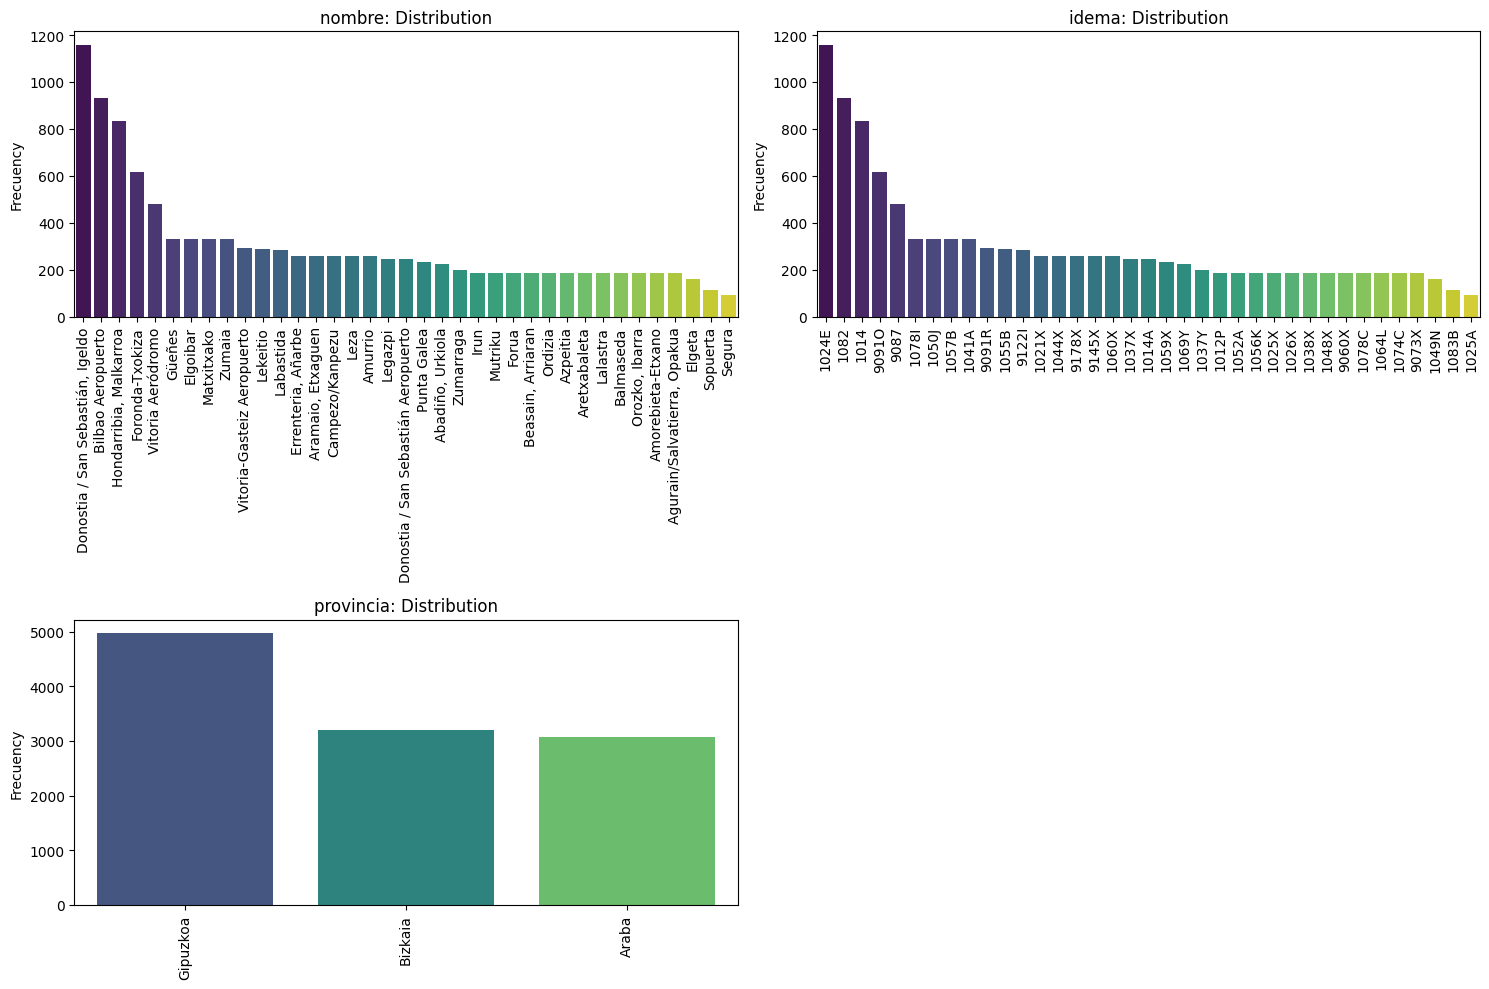

In [11]:
# "idema" would be the main categorical variable. "provincia" and "nombre" are correlated with "idema"
categorical_columns = ['nombre', 'idema', 'provincia']

viz.plot_multiple_categorical_distributions(df_weather, categorical_columns, show_values = False, rotation = 90)

As expected, we can see the three capitals of Basque Country provinces (Bilbao, Donostia and Vitoria-Gasteiz) in the top 5 of cities with weather data information, or at least close the main cities.

1. Donostia, Igeldo, the closest mountain to the city
2. Bilbao airport, located in Loiu, aproximately 10 km to Bilbao city center.
3. Hondarribia-Malkarroa, aproximately 20 km to Donostia city center.
4. Foronda-Txokiza, close to Vitoria-Gasteiz airport, less than 10 km to the city center.
5. Vitoria Airfield, less than 10 km to the Vitoria-Gasteiz city center.

In [12]:
# # Show idema, location, and service time
# f.show_AWS_info(df_weather)

# print('-------------')

# # Group by 'idema' and filter out those groups that do not have data for at least 25 years
# df_weather_eda = df_weather.groupby('idema').filter(lambda x: (x['fecha'].max() - x['fecha'].min()).days/365 >= 25)

# for idema in df_weather_eda['idema'].unique():   
#     AWS_name = df_weather_eda[df_weather_eda['idema'] == idema]['nombre'].unique()[0]
#     min_date = df_weather_eda[df_weather_eda['idema'] == idema]['fecha'].min().strftime('%Y-%m')
#     max_date = df_weather_eda[df_weather_eda['idema'] == idema]['fecha'].max().strftime('%Y-%m')
#     print(f'{idema} : {AWS_name} --> Data from {min_date} to {max_date}.')

## 4.3 - Numerical variables

First I am going to analyze all the data together (knowing there are a lot of missing values) but just for get the distribution of the parameters and look for outliers.

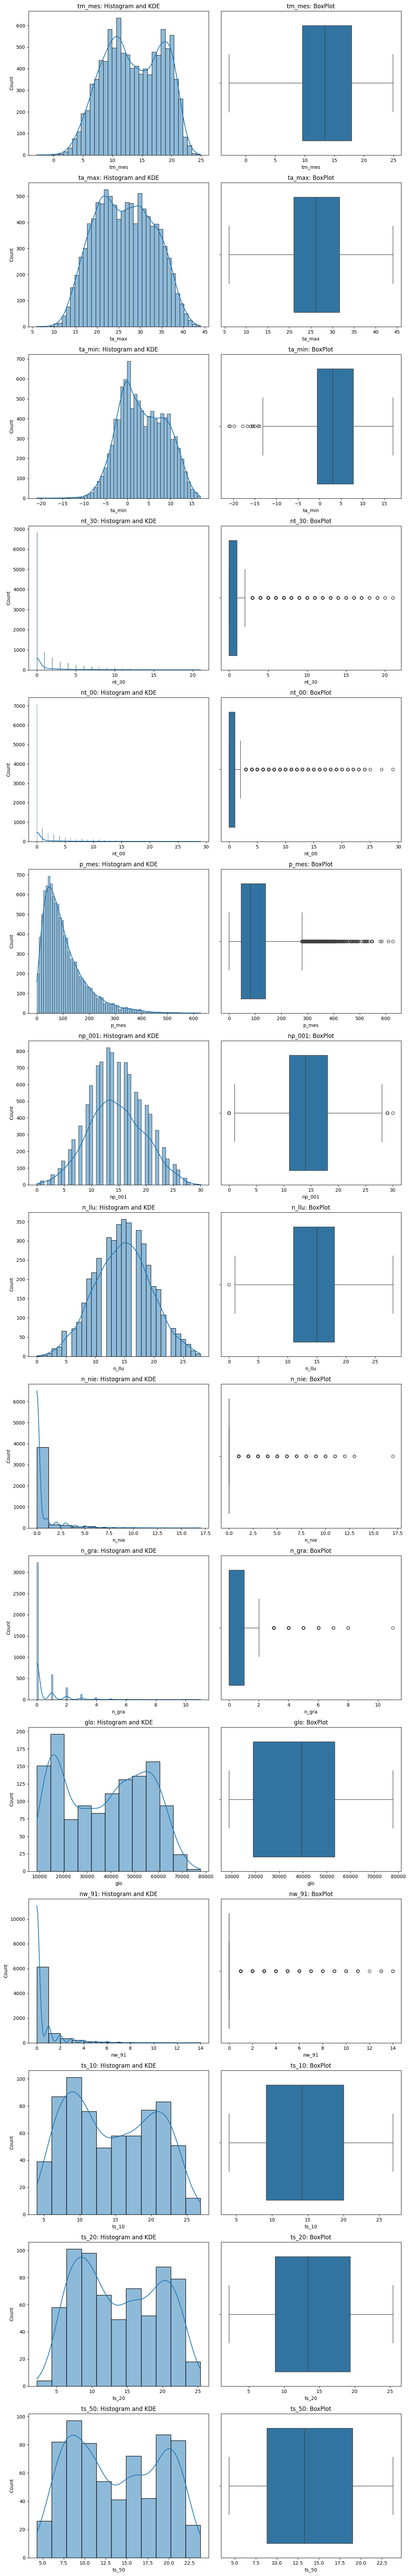

In [13]:
numeric_columns = ['tm_mes', 'ta_max', 'ta_min', 'nt_30', 'nt_00', 
                  'p_mes', 'np_001', 'n_llu', 'n_nie', 'n_gra',
                  'glo', 'nw_91', 'ts_10', 'ts_20', 'ts_50']

viz.plot_multiple_histograms_KDEs_boxplots(df_weather, numeric_columns)

Interesting information but not so easily understandable as long as all the data is mixed. 
- The outliers are  valid as long as the correspond to metereological phenomenons.

Let's think about different analisys we could perform:
- Temporal analysis
    - Temperature tendency ("tm_mes", "ta_max", "ta_min")
    - Precipitation patterns ("p_mes", "n_llu")
- Geografic comparison
    - Analisys by province
    - Altitud effect
- Extreme climate events
    - Extremely hot and cold days ("nt_30" and "nt_00")
    - Extreme precipitations ("np_001", "n_llu", "n_gra")
- If needed treatment of missing values

## 4.4 - Temporal analysis

I am going to group the data by station and see the evolution of the temperature, but first I want to know the life time of each AWS.

In [14]:
# Show idema, location, and service time of all AWSs in Basque Country
f.show_AWS_info(df_weather)


1012P : Irun --> Data from 2009-01 to 2024-06.
1014 : Hondarribia, Malkarroa --> Data from 1955-01 to 2024-06.
1014A : Donostia / San Sebastián Aeropuerto --> Data from 2004-01 to 2024-06.
1021X : Errenteria, Añarbe --> Data from 2003-01 to 2024-06.
1024E : Donostia / San Sebastián, Igeldo --> Data from 1928-01 to 2024-06.
1025A : Segura --> Data from 2017-01 to 2024-06.
1025X : Beasain, Arriaran --> Data from 2009-01 to 2024-06.
1026X : Ordizia --> Data from 2009-01 to 2024-06.
1037X : Legazpi --> Data from 2003-01 to 2024-06.
1037Y : Zumarraga --> Data from 2008-01 to 2024-06.
1038X : Azpeitia --> Data from 2009-01 to 2024-06.
1041A : Zumaia --> Data from 1997-01 to 2024-06.
1044X : Aramaio, Etxaguen --> Data from 2003-01 to 2024-06.
1048X : Aretxabaleta --> Data from 2009-01 to 2024-06.
1049N : Elgeta --> Data from 2011-01 to 2024-06.
1050J : Elgoibar --> Data from 1997-01 to 2024-06.
1052A : Mutriku --> Data from 2009-01 to 2024-06.
1055B : Lekeitio --> Data from 1997-01 to 2020-12

There are to many AWS to do the analysis, and many of them do not have enought data, so I am going to filter to stations that at least have 50 years of temperature information.

It won't involve this analysis, but, Vitoria Airfield AWS was deprecated in 1982, so we won't use it anyway.

In [15]:
# Group by 'idema' and filter out those groups that do not have data for at least 50 years of data
df_weather_eda = df_weather.groupby('idema').filter(lambda x: (x['fecha'].max() - x['fecha'].min()).days/365 >= 50)

f.show_AWS_info(df_weather_eda)


1014 : Hondarribia, Malkarroa --> Data from 1955-01 to 2024-06.
1024E : Donostia / San Sebastián, Igeldo --> Data from 1928-01 to 2024-06.
1082 : Bilbao Aeropuerto --> Data from 1947-01 to 2024-06.
9091O : Foronda-Txokiza --> Data from 1973-01 to 2024-06.


In [16]:
df_weather_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3540 entries, 195 to 10331
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   idema      3540 non-null   object        
 1   fecha      3540 non-null   datetime64[ns]
 2   nombre     3540 non-null   object        
 3   provincia  3540 non-null   object        
 4   altitud    3540 non-null   int64         
 5   tm_mes     3499 non-null   float64       
 6   ta_max     3504 non-null   float64       
 7   ta_min     3503 non-null   float64       
 8   nt_30      3504 non-null   float64       
 9   nt_00      3503 non-null   float64       
 10  p_mes      3507 non-null   float64       
 11  np_001     3506 non-null   float64       
 12  n_llu      3504 non-null   float64       
 13  n_nie      3504 non-null   float64       
 14  n_gra      3504 non-null   float64       
 15  glo        796 non-null    float64       
 16  nw_91      3064 non-null   float64       
 1

In [17]:
# Create a dictionary to store "df_weather_eda" DataFrames by "idema"
sub_dataframes = {}

for idema in df_weather_eda['idema'].unique():
    # Filter the original DataFrame by "idema"
    df_idema = df_weather_eda[df_weather_eda['idema'] == idema].copy()
    # Storage the DataFrame in the dictionary with an unique key
    sub_dataframes[f'{idema}'] = df_idema

Index type:  datetime64[ns]
1014 : Hondarribia, Malkarroa --> Data from 1955-01 to 2024-06.


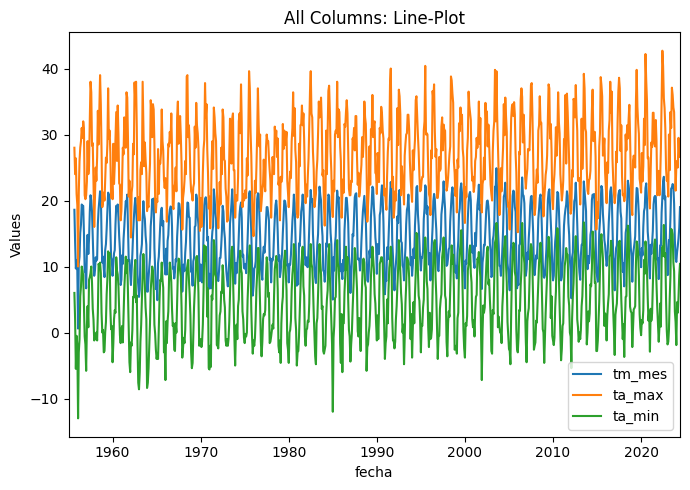

Index type:  datetime64[ns]
1024E : Donostia / San Sebastián, Igeldo --> Data from 1928-01 to 2024-06.


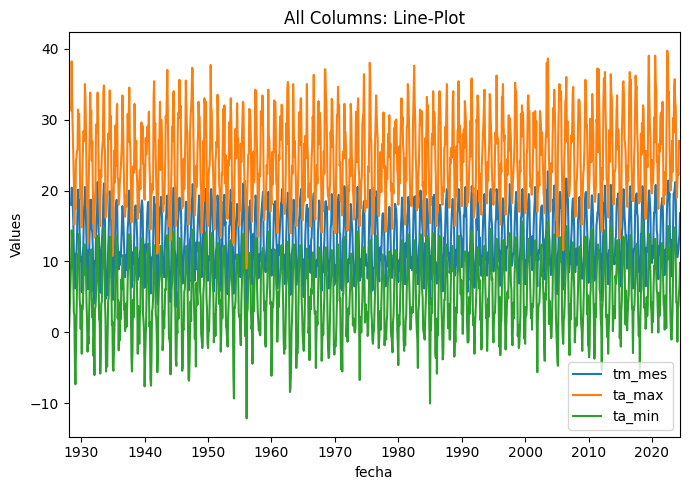

Index type:  datetime64[ns]
1082 : Bilbao Aeropuerto --> Data from 1947-01 to 2024-06.


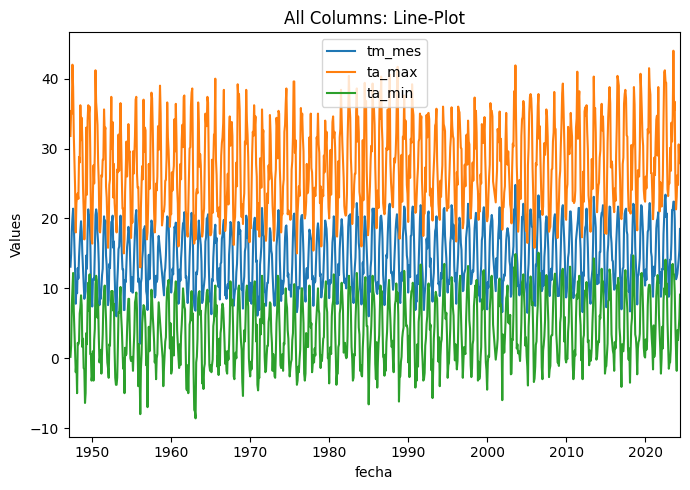

Index type:  datetime64[ns]
9091O : Foronda-Txokiza --> Data from 1973-01 to 2024-06.


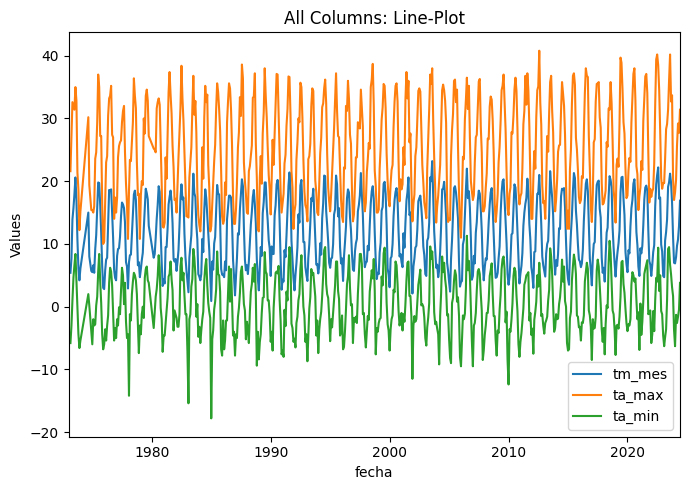

In [18]:
# plot temperature evolution vs timeline
for idema in df_weather_eda['idema'].unique():
    # df construction to use lineplot() function
    df_idema = sub_dataframes[idema]
    df_idema = df_idema.set_index('fecha')
    print('Index type: ', df_idema.index.dtype)
    
    AWS_name = df_idema['nombre'].unique()[0]
    min_date = str(df_idema.index.min().strftime('%Y-%m'))
    max_date = str(df_idema.index.max().strftime('%Y-%m'))
    print(f'{idema} : {AWS_name} --> Data from {min_date} to {max_date}.')
    
    # Temperature evolution
    viz.lineplot_multiple(df_idema, ['tm_mes', 'ta_max', 'ta_min'], all_together = True)


Data here is too variable because I am evaluating every month. I should do the mean value per year so we can distinguish a tendency.


1014 : Hondarribia, Malkarroa --> Data from 1955 to 2024.
Slope:  0.030916513574198664


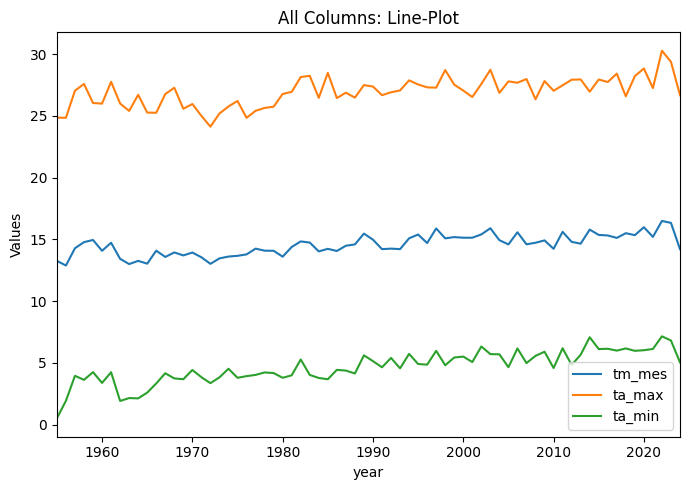

1024E : Donostia / San Sebastián, Igeldo --> Data from 1928 to 2024.
Slope:  0.0104998378217264


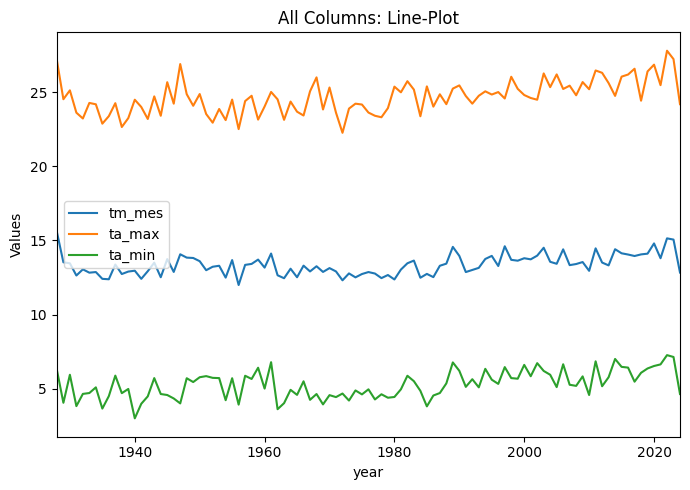

1082 : Bilbao Aeropuerto --> Data from 1947 to 2024.
Slope:  0.022950455119615732


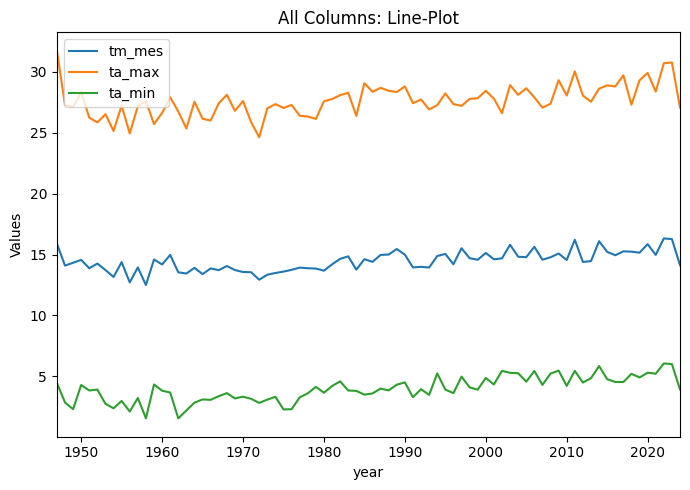

9091O : Foronda-Txokiza --> Data from 1973 to 2024.
Slope:  0.03185036569054262


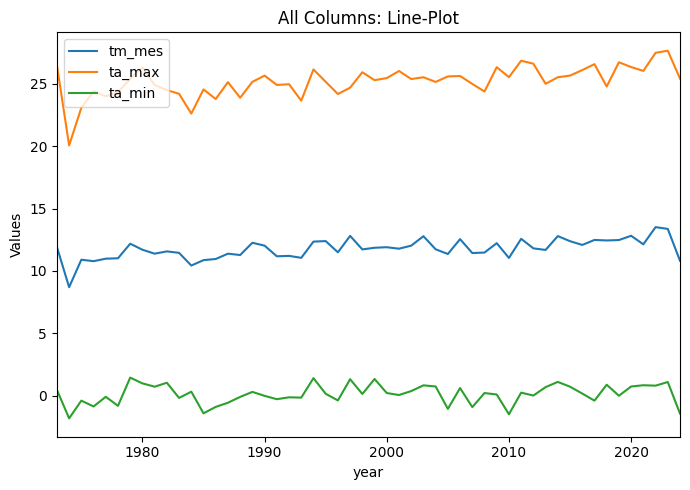

Maximum temperature slope =  0.03185036569054262


In [19]:
# Slope of the temperature variation
slopes = []

# plot mean temperature per year vs timeline
for idema in df_weather_eda['idema'].unique():
    df_idema = sub_dataframes[idema]
    df_idema['year'] = df_idema['fecha'].dt.year

    # Group by year and calculate the mean of temperature columns
    df_yearly = df_idema.groupby('year').agg({'tm_mes': 'mean', 'ta_max': 'mean', 'ta_min': 'mean'}).reset_index()
    df_yearly.set_index('year', inplace=True)
    # display(df_yearly)
    
    AWS_name = df_idema['nombre'].unique()[0]
    min_date = str(df_yearly.index.min())
    max_date = str(df_yearly.index.max())
    print(f'{idema} : {AWS_name} --> Data from {min_date} to {max_date}.')
    
    # Calculate the slope using numpy.polyfit (very simple way)
    tm_mes_slope, tm_mes_intercept = np.polyfit(df_yearly.index, df_yearly.tm_mes, 1)
    print('Slope: ', tm_mes_slope)
    
    viz.lineplot_multiple(df_yearly, ['tm_mes', 'ta_max', 'ta_min'], all_together = True)
    
    slopes.append(tm_mes_slope)

print('Maximum temperature slope = ', np.max(slopes))
    

The information of this graphs is quite important.
- Temperature increasing has an slope of up to 0.032 ºC/year, which meand 1.5ºC in the last 50 years.
- That value is very important because a 1.5°C of global temperature increase refers to the goal set by the Paris Agreement to limit the global average temperature rise above pre-industrial levels. This is a critical threshold scientists have identified as a limit beyond which the risks of severe and irreversible impacts of climate change significantly increase.

1014 : Hondarribia, Malkarroa --> Data from 1955 to 2024.
Slope:  nan


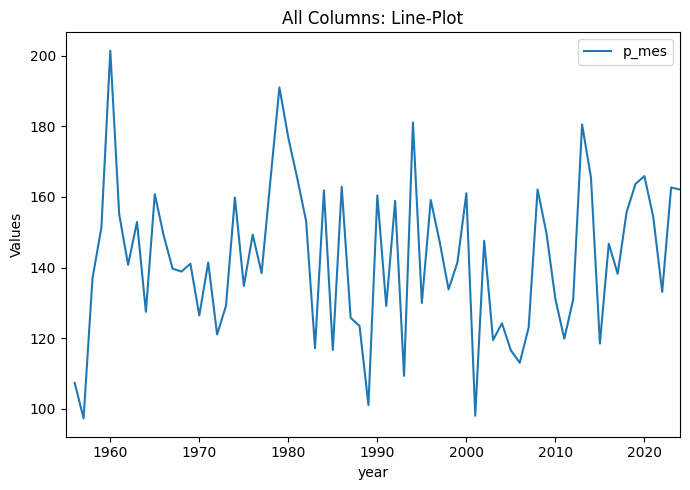

1024E : Donostia / San Sebastián, Igeldo --> Data from 1928 to 2024.
Slope:  0.010010234764008044


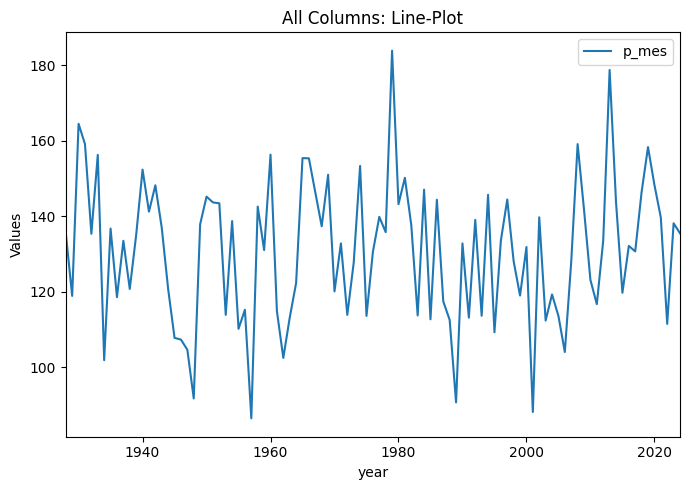

1082 : Bilbao Aeropuerto --> Data from 1947 to 2024.
Slope:  -0.15293918011409954


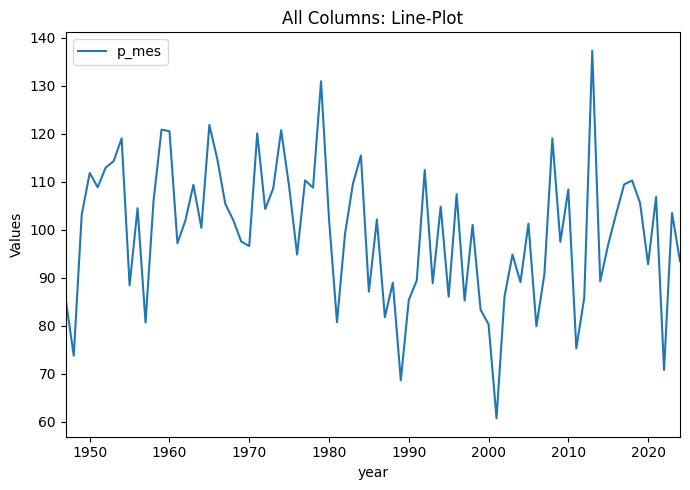

9091O : Foronda-Txokiza --> Data from 1973 to 2024.
Slope:  -0.14098466091805792


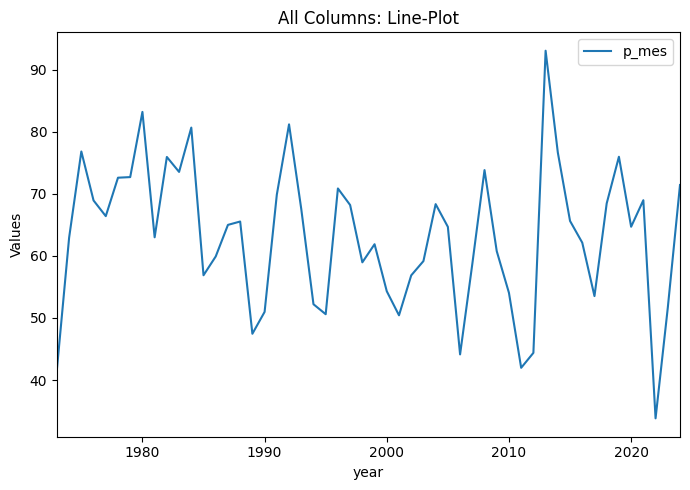

Maximum temperature slope =  nan


In [20]:
# Slope of the precipitation variation
slopes = []

for idema in df_weather_eda['idema'].unique():
    df_idema = sub_dataframes[idema]
    df_idema['year'] = df_idema['fecha'].dt.year

    # Group by year and calculate the mean of temperature columns
    df_yearly = df_idema.groupby('year').agg({'p_mes': 'mean'}).reset_index()
    df_yearly.set_index('year', inplace=True)
    # display(df_yearly)
    
    AWS_name = df_idema['nombre'].unique()[0]
    min_date = str(df_yearly.index.min())
    max_date = str(df_yearly.index.max())
    print(f'{idema} : {AWS_name} --> Data from {min_date} to {max_date}.')
    
    # Calculate the slope using numpy.polyfit (very simple way)
    tm_mes_slope, tm_mes_intercept = np.polyfit(df_yearly.index, df_yearly.p_mes, 1)
    print('Slope: ', tm_mes_slope)
    
    viz.lineplot_multiple(df_yearly, ['p_mes'], all_together = True)
    
    slopes.append(tm_mes_slope)

print('Maximum temperature slope = ', np.max(slopes))
    

There is no clear conclusion on the evolution of precipitation because the results fluctuate too much.

## 4.5 Geographical comparison